## Integrating Word2Vec - Pt.2

In [83]:
%pip install -q numpy pandas matplotlib seaborn scikit-learn gensim portalocker>=2.0.0
%pip install torchdata==0.7.1
%pip install torch==2.2.2+cpu torchtext==0.17.2+cpu \
    --index-url https://download.pytorch.org/whl/cpu

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Looking in indexes: https://download.pytorch.org/whl/cpuNote: you may need to restart the kernel to use updated packages.



This script defines a **utility function**, **"find_similar_words"**, to identify words most similar to a given target word using word embeddings. It computes cosine similarity between word vectors to find the closest matches. This helps in NLP tasks like synonym discovery, word clustering, and semantic analysis.


In [3]:
%%writefile utils.py

import numpy as np

def find_similar_words(target_word, embedding_dict, top_k=2):
    if target_word not in embedding_dict:
        return f"Word '{target_word}' not found in embeddings."
    
    target_vector = embedding_dict[target_word]
    similarities = {}

    for word, vector in embedding_dict.items():
        if word == target_word:
            continue
        similarity = np.dot(target_vector, vector) / (np.linalg.norm(target_vector) * np.linalg.norm(vector))
        similarities[word] = similarity

    sorted_words = sorted(similarities.items(), key=lambda x: x[1], reverse=True)
    return [word for word, _ in sorted_words[:top_k]]

Writing utils.py


### Step 1: Import the required libraries

In [4]:
import matplotlib.pyplot as plt

from gensim.models import Word2Vec
from collections import defaultdict
import torch
import torch.nn as nn

from torchtext.vocab import GloVe,vocab

from torchtext.datasets import AG_NEWS
train_iter_ag_news = AG_NEWS(split="train")
from torch.utils.data.dataset import random_split
from torchtext.data.functional import to_map_style_dataset
from torchtext.data.utils import get_tokenizer
from torch.utils.data import DataLoader
from tqdm import tqdm
from utils import find_similar_words

%matplotlib inline

# You can also use this section to suppress warnings generated by your code:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings('ignore')


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

### Load Stanford Glove Model

Transfer learning, particularly through the use of pretrained word embeddings, serves as a cornerstone in modern NLP. This approach leverages knowledge gleaned from one task, typically learned over massive datasets, and applies it to another, often more specialized task. The primary advantage of this is twofold: it bypasses the need for enormous computational resources to learn from scratch, and it injects a base layer of linguistic understanding into the model. By using embeddings that have already captured complex language patterns and associations, even models with limited exposure to domain-specific data can exhibit remarkably sophisticated behavior, making transfer learning a strategic shortcut to enhanced performance in NLP.


We can specify the model name and embedding dimension: GloVe(name='GloVe_model_name', dim=300)


In [6]:
# creating an instance of the 6B version of Glove() model
glove_vectors_6B = GloVe(name ='6B') # you can specify the model with the following format: GloVe(name='840B', dim=300)

.vector_cache\glove.6B.zip: 862MB [04:12, 3.41MB/s]                               
100%|█████████▉| 399999/400000 [00:49<00:00, 8160.39it/s] 


In [7]:
# load the glove model pretrained weights into a PyTorch embedding layer
embeddings_Glove6B = torch.nn.Embedding.from_pretrained(glove_vectors_6B.vectors,freeze=True)

Let us look into the embedding vectors of this large pretrained model for the words in the corpus:

We can create an array that returns the index of each word in the GloVe model's vocabulary:


In [8]:
word_to_index = glove_vectors_6B.stoi  # Vocabulary index mapping
word_to_index['team']

145

We will get the embedded vector for a word:


In [9]:
embeddings_Glove6B.weight[word_to_index['team']]

tensor([-2.7011e-02,  1.1299e+00,  4.4708e-02, -4.0380e-01, -4.7284e-02,
         9.2736e-02, -2.0715e-01,  2.6137e-01,  2.4730e-01, -8.8769e-01,
         3.1309e-01, -1.4940e-01,  4.9929e-03, -1.1520e-01, -1.7990e-01,
         6.4681e-01,  1.5044e-01, -3.4580e-01,  2.3370e-03, -7.5788e-01,
         1.6048e-01, -2.9066e-02,  1.7194e-01, -4.2799e-02,  3.4297e-02,
        -1.1400e-01, -2.1149e-01,  3.6118e-01, -3.3393e-01, -1.3581e-01,
         1.7858e-01, -2.3381e-01, -8.3367e-02,  1.0626e-01, -1.7301e+00,
         5.2052e-01,  3.7855e-01,  5.5852e-01, -1.0172e-01, -1.8644e-01,
        -1.2096e-01, -5.2009e-02,  1.9565e-01, -1.2685e-01, -3.7493e-01,
         9.7457e-02,  1.7014e-01,  7.7521e-02, -2.1946e-01,  1.4490e-01,
         1.2733e-01, -2.2223e-01, -3.1548e-01,  1.1137e-01, -4.0263e-01,
         8.3553e-01, -7.5475e-03,  3.6725e-01,  1.2324e-02, -1.0033e-01,
        -6.0014e-01,  4.2763e-01, -2.4048e-01, -2.8162e-01,  4.6409e-02,
        -3.7942e-01, -8.0836e-02, -3.2884e-01, -9.3

Let us see how successful the Glove model is in capturing the similarities between words:


In [10]:
# an array of example words
words = [
    "taller",
    "short",
    "black",
    "white",
    "dress",
    "pants",
    "big",
    "small",
    "red",
    "blue",
    "smile",
    "frown",
    "race",
    "stroll",
    "tiny",
    "huge",
    "soft",
    "rough",
    "team",
    "individual"
]


Create a dictionary of words and their embeddings


In [11]:

embedding_dict_Glove6B = {}
for word in words:
    # Get the index of the word from the vocabulary to access its embedding
    embedding_vector = embeddings_Glove6B.weight[word_to_index[word]]
    if embedding_vector is not None:
        # Words not found in the embedding index will be skipped.
        # add the embedding vector of word to the embedding_dict_Glove6B
        embedding_dict_Glove6B[word] = embedding_vector


Now that we have loaded the pretrained embeddings for the sample words, let's check if the model can capture the similarity of words by finding the distance between words:


In [12]:
# Call the function to find similar words
target_word = "small"
top_k=2
similar_words = find_similar_words(target_word, embedding_dict_Glove6B, top_k)

# Print the similar words
print("{} most similar words to {}:".format(top_k,target_word) ,similar_words)

2 most similar words to small: ['tiny', 'big']


It can be seen the pretrained GloVe model does quite a good job capturing the similarity of words.


### Train a Word2Vec Model from Genism

#### Prepare our corpus: 

In [13]:
sentences = [["I", "like", "to", "eat", "pizza"],
             ["Pizza", "is", "my", "favorite", "food"],
             ["I", "enjoy", "eating", "pasta"]]
sentences = [[word.lower() for word in sentence] for sentence in sentences]


The `size` parameter specifies the dimensionality of the word embeddings (in this case, 100). The `window` parameter determines the size of the context window. The `min_count` parameter sets the minimum frequency of a word to be included in the training process. Finally, the `workers` parameter controls the number of threads used for training.


In [14]:
from gensim.models import Word2Vec

# Create an instance of Word2Vec model
w2v_model = Word2Vec(sentences, vector_size=100, window=3, min_count=1, workers=4)

Create vocab from sentences:


In [15]:
# Build vocab using the training data
w2v_model.build_vocab(sentences, progress_per=10000)

Train the model:

In [16]:
# Train the model on your training data
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

(55, 420)

That's it! We've trained a word2vec model using the `gensim` library. We can now access the word embeddings using `model.wv` and explore various operations such as finding similar words, calculating word similarities, and more.


Use the trained model to find similar words to "pizza" and calculate the similarity between "pizza" and "pasta". 


In [17]:
# Finding similar words
similar_words = w2v_model.wv.most_similar("pizza")
print("Similar words to 'pizza':", similar_words)

# Calculating word similarity
similarity = w2v_model.wv.similarity("pizza", "pasta")
print("Similarity between 'pizza' and 'pasta':", similarity)

Similar words to 'pizza': [('to', 0.17027318477630615), ('is', 0.13898280262947083), ('my', 0.035433270037174225), ('like', 0.00451968889683485), ('pasta', -0.005902299657464027), ('i', -0.027743974700570107), ('favorite', -0.028113720938563347), ('eat', -0.04430948570370674), ('food', -0.06873457878828049), ('enjoy', -0.1732126623392105)]
Similarity between 'pizza' and 'pasta': -0.00590231


The word embeddings obtained from the model would be more meaningful and informative with larger and more diverse training data.


Use the trained model to create a PyTorch embedding layer (just like what we did with the pretrained GloVe model) and use it in any task as an embedding layer.


In [18]:
# Extract word vectors and create word-to-index mapping
word_vectors = w2v_model.wv
# a dictionary to map words to their index in vocab
word_to_index = {word: index for index, word in enumerate(word_vectors.index_to_key)}

# Create an instance of nn.Embedding and load it with the trained vectors
embedding_dim = w2v_model.vector_size
embedding = torch.nn.Embedding(len(word_vectors.index_to_key), embedding_dim)
embedding.weight.data.copy_(torch.from_numpy(word_vectors.vectors))

# Example usage: get the embedding for a word
word = "pizza"
word_index = word_to_index[word]
word_embedding = embedding(torch.LongTensor([word_index]))
print(f"Word: {word}, Embedding: {word_embedding.detach().numpy()}")

Word: pizza, Embedding: [[-0.00714092  0.00124133 -0.00717793 -0.00224098  0.00372044  0.00583255
   0.00120101  0.00210401 -0.00411258  0.00722417 -0.00630454  0.00464709
  -0.00821901  0.00203745 -0.00497656 -0.00424712 -0.00310588  0.00565446
   0.00579693 -0.00497813  0.00077411 -0.00849433  0.00781365  0.00925739
  -0.00274148  0.00080058  0.00074548  0.00547892 -0.00860763  0.00058273
   0.00687327  0.00223279  0.0011247  -0.00932057  0.00847972 -0.00626165
  -0.00299271  0.00349315 -0.0007744   0.00141046  0.00178483 -0.00682816
  -0.00972361  0.00903822  0.00620081 -0.00691076  0.00340142  0.0002056
   0.00475387 -0.00712     0.00402757  0.0043473   0.00995535 -0.0044746
  -0.00139121 -0.00732087 -0.00969911 -0.00908164 -0.00102246 -0.00650654
   0.0048497  -0.00616394  0.00252445  0.00073935 -0.00339426 -0.0009791
   0.0099768   0.00914695 -0.00446548  0.00908081 -0.00564203  0.00593325
  -0.00309734  0.00343278  0.00301738  0.00689681 -0.00237353  0.00877608
   0.00758863 -0.

### Text Classification Using Pretrained Word Embeddings

Let us use the pretrained embeddings to classify text data into topics:

First, let us build vocab from the pretrained GloVe

In [19]:
from torchtext.vocab import GloVe,vocab
# Build vocab from glove_vectors
# vocab(ordered_dict: Dict, min_freq: int = 1, specials: Optional[List[str]] = None)
vocab = vocab(glove_vectors_6B.stoi, 0,specials=('<unk>', '<pad>'))
vocab.set_default_index(vocab["<unk>"])

In [20]:
vocab(["<unk>","Hello","hello"])

[0, 0, 13077]

Next, we will need to tokenize the text. For this we can use pretrained tokenizers from torch:

In [21]:
# Define tokenizer

tokenizer = get_tokenizer("basic_english")
# Define functions to process text and labels

Create splits from AG_NEWS() dataset for training, validation and test:

In [22]:
# Split the dataset into training and testing iterators.
train_iter, test_iter = AG_NEWS()

# Convert the training and testing iterators to map-style datasets.
train_dataset = to_map_style_dataset(train_iter)
test_dataset = to_map_style_dataset(test_iter)

# Determine the number of samples to be used for training and validation (5% for validation).
num_train = int(len(train_dataset) * 0.85)

# Randomly split the training dat aset into training and validation datasets using `random_split`.
# The training dataset will contain 95% of the samples, and the validation dataset will contain the remaining 5%.
split_train_, split_valid_ = random_split(train_dataset, [num_train, len(train_dataset) - num_train])

Define the class labels:

In [23]:
# define class labels
ag_news_label = {1: "World", 2: "Sports", 3: "Business", 4: "Sci/Tec"}
'''ag_news_label[y]'''
num_class = len(set([label for (label, text) in train_iter ]))

Collate data in batches:

In [24]:
def text_pipeline(x):
    x=x.lower()# you need this as your vocab is in lower case
    return vocab(tokenizer(x))

def label_pipeline(x):
    return int(x) - 1

# create label, text and offset for each batch of data
# text is the concatenated text for all text data in the batch
# you need to have the offsets(the end of text index) for later when you separate texts and predict their label
def collate_batch(batch):
    label_list, text_list, offsets = [], [], [0]
    for _label, _text in batch:
        label_list.append(label_pipeline(_label))
        processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64)
        text_list.append(processed_text)
        offsets.append(processed_text.size(0))

    label_list = torch.tensor(label_list, dtype=torch.int64)
    offsets = torch.tensor(offsets).cumsum(dim=0)
    text_list = torch.cat(text_list)
    return label_list.to(device), text_list.to(device), offsets.to(device)


Create data loaders for train, validation and test splits: 

In [25]:
BATCH_SIZE = 64

train_dataloader = DataLoader(
    split_train_, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch
)
valid_dataloader = DataLoader(
    split_valid_, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch
)
test_dataloader = DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch
)

In [26]:
label, text, offsets=next(iter(train_dataloader ))
print(label, text, offsets)
label.shape, text.shape, offsets.shape

tensor([0, 0, 3, 0, 3, 3, 3, 3, 3, 1, 1, 3, 0, 3, 2, 1, 2, 0, 1, 2, 2, 0, 0, 3,
        1, 1, 2, 3, 3, 0, 1, 3, 3, 1, 1, 3, 2, 0, 0, 3, 1, 2, 0, 1, 3, 1, 3, 1,
        1, 2, 1, 2, 2, 1, 3, 0, 2, 3, 2, 0, 1, 1, 0, 0]) tensor([13884,   500,  2146,  ...,  1536,   338,     4]) tensor([   0,   36,   77,  103,  132,  181,  220,  275,  339,  383,  429,  464,
         524,  566,  612,  670,  703,  752,  794,  835,  872,  919,  956,  997,
        1030, 1058, 1102, 1143, 1189, 1237, 1284, 1325, 1376, 1453, 1494, 1552,
        1579, 1627, 1683, 1726, 1772, 1806, 1849, 1899, 1935, 1975, 2013, 2070,
        2129, 2175, 2212, 2249, 2287, 2329, 2369, 2420, 2459, 2505, 2555, 2591,
        2645, 2688, 2722, 2763, 2807])


(torch.Size([64]), torch.Size([2807]), torch.Size([65]))

Create the classifier model:

In [27]:
class TextClassificationModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_class):
        super(TextClassificationModel, self).__init__()
        self.embedding = torch.nn.Embedding.from_pretrained(glove_vectors_6B.vectors,freeze=True)
        self.fc = nn.Linear(embed_dim, num_class)
        self.init_weights()

    def init_weights(self):
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()

    def forward(self, text,offsets):
        embedded = self.embedding(text)
        # you get the average of word embeddings in the text
        means = []
        for i in range(1,len(offsets)):
            #this is like eme
          text_tmp = embedded[offsets[i-1]:offsets[i]]
          means.append(text_tmp.mean(0))

        return self.fc(torch.stack(means))

Define an evaluate function to calculate the accuracy of model:

In [28]:
def evaluate(dataloader):
    model.eval()
    total_acc, total_count= 0, 0

    with torch.no_grad():
        for idx, (label, text, offsets) in enumerate(dataloader):
            predicted_label = model(text,offsets)

            total_acc += (predicted_label.argmax(1) == label).sum().item()
            total_count += label.size(0)
    return total_acc / total_count

Create an instance of the model and check its prediciton power before training:

In [29]:
# Define hyperparameters
vocab_size=len(vocab)
embedding_dim = 300
# Initialize the model
model = TextClassificationModel(vocab_size, embedding_dim, num_class).to(device)

In [30]:
evaluate(test_dataloader)

0.21894736842105264

Let us train the model:

In [31]:
def train_TextClassification(model,dataloader,criterion,optimizer,epochs=10):
    
    cum_loss_list=[]
    acc_epoch=[]
    acc_old=0

    for epoch in tqdm(range(1, EPOCHS + 1)):
        model.train()
        cum_loss=0
        for idx, (label, text, offsets) in enumerate(train_dataloader):
            means = []
            optimizer.zero_grad()
            

            predicted_label = model(text, offsets)
            
            loss = criterion(predicted_label, label)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
            optimizer.step()
            cum_loss+=loss.item()

        cum_loss_list.append(cum_loss/len(train_dataloader))
        accu_val = evaluate(valid_dataloader)
        acc_epoch.append(accu_val)

        if accu_val > acc_old:
          acc_old= accu_val
          torch.save(model.state_dict(), 'my_model.pth')
            
    return model,cum_loss_list,acc_epoch


In [32]:
# Define hyperparameters
LR=0.1
EPOCHS = 10


criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)

model,cum_loss_list,acc_epoch  = train_TextClassification(model,train_dataloader,criterion,optimizer,EPOCHS)

100%|██████████| 10/10 [02:15<00:00, 13.57s/it]


Let us plot the loss and accuracy for the traind model: 

In [33]:
import matplotlib.pyplot as plt
def plot(COST,ACC):
    fig, ax1 = plt.subplots()
    color = 'tab:red'
    ax1.plot(COST, color=color)
    ax1.set_xlabel('epoch', color=color)
    ax1.set_ylabel('total loss', color=color)
    ax1.tick_params(axis='y', color=color)

    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.set_ylabel('accuracy', color=color)  # you already handled the x-label with ax1
    ax2.plot(ACC, color=color)
    ax2.tick_params(axis='y', color=color)
    fig.tight_layout()  # otherwise the right y-label is slightly clipped

    plt.show()

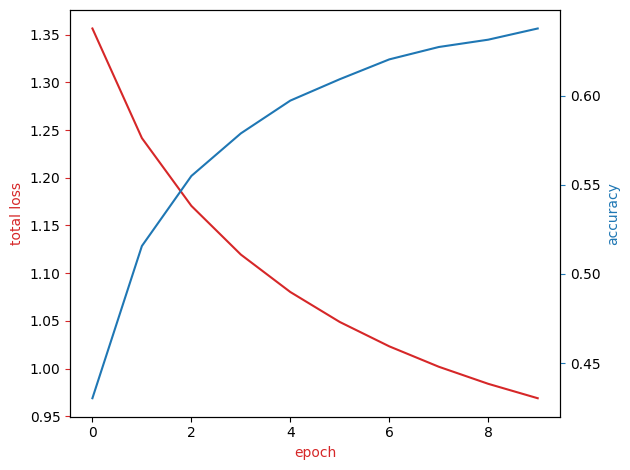

In [34]:
plot(cum_loss_list,acc_epoch)

Finally, evaluate the model on test data:

In [35]:
evaluate(test_dataloader)

0.6310526315789474